In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import datetime

## Final Project for DTSA-5509
Alexi Salazar

4/30/24

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependencies installed in your build. 

All required packages are listed above. Thanks for taking the time to grade my work!

For this project, I wanted to gain familiarity with machine learning algorithms and really just experience building a "working" model. I went onto Redfin and was able to acquire data for California that listed the median sale price of all listings from 
January 2012 all the way to March 2024. This file had data for Cities as well as Zip codes.  

My Supervised Machine Learning objective was to create a model that can forecast the future home prices.

For my project, I predominantly utilized Linear Regression - more specifically Ridge Regression.  Ridge Regression is a linear regression technique that adds a penalty term to the ordinary least squares (OLS) objective function to regularize the model. This penalty term helps to prevent overfitting by shrinking the coefficients towards zero, thereby reducing the model's complexity.

In my case, the Ridge Regression model was trained on historical housing price data to try and predict future housing prices.

## Exploratory Data Analysis and Data Cleaning

Before anything, we have to load the data and get familiar with it so that when we do manipulate it, we can do so effectively.

In [26]:
# Load and preprocess data
House_median = pd.read_csv("https://raw.githubusercontent.com/Alexi013/California-Housing/main/med_sale_price.csv", delimiter='\t', skiprows=1, encoding='utf-16')

print(House_median.head())
print("Data shape:", House_median.shape)
print("Data columns:", House_median.columns)
print("Data types:\n", House_median.dtypes)
print("Summary statistics:\n", House_median.describe())
print(House_median.head())

                       Region January 2012 February 2012 March 2012  \
0  Los Angeles, CA metro area        $290K         $300K      $310K   
1          Acalanes Ridge, CA        $992K         $590K      $743K   
2                  Acampo, CA          NaN         $250K      $174K   
3                   Acton, CA        $365K         $340K      $373K   
4                Adelanto, CA          NaN          $83K       $87K   

  April 2012 May 2012 June 2012 July 2012 August 2012 September 2012  ...  \
0      $315K    $320K     $330K     $335K       $337K          $349K  ...   
1        NaN    $961K     $600K     $671K       $605K          $870K  ...   
2      $259K    $205K     $223K     $165K       $433K        $1,600K  ...   
3      $256K    $345K     $360K     $396K       $362K          $369K  ...   
4       $75K     $85K      $83K      $95K        $86K          $102K  ...   

  June 2023 July 2023 August 2023 September 2023 October 2023 November 2023  \
0     $862K     $860K       $86

After loading and previewing the data, we can work to replace "NaN" data.

In [28]:
House_median.fillna(0, inplace=True)

price_columns = House_median.columns[1:]  # Exclude the 'Region' column

House_median[price_columns] = House_median[price_columns].replace(r'\D', '', regex=True).astype(float)

print("Data shape:", House_median.shape)
print("Data columns:", House_median.columns)
print("Data types:\n", House_median.dtypes)
print("Summary statistics:\n", House_median.describe())
print(House_median.head())

Data shape: (3271, 148)
Data columns: Index(['Region', 'January 2012', 'February 2012', 'March 2012', 'April 2012',
       'May 2012', 'June 2012', 'July 2012', 'August 2012', 'September 2012',
       ...
       'June 2023', 'July 2023', 'August 2023', 'September 2023',
       'October 2023', 'November 2023', 'December 2023', 'January 2024',
       'February 2024', 'March 2024'],
      dtype='object', length=148)
Data types:
 Region            object
January 2012     float64
February 2012    float64
March 2012       float64
April 2012       float64
                  ...   
November 2023    float64
December 2023    float64
January 2024     float64
February 2024    float64
March 2024       float64
Length: 148, dtype: object
Summary statistics:
        January 2012  February 2012   March 2012   April 2012     May 2012  \
count   3271.000000    3271.000000  3271.000000  3271.000000  3271.000000   
mean     239.316723     249.824213   250.929379   269.093244   282.336594   
std      364.394

In [31]:
# Calculate yearly mean price
new_House_median['Mean_Price_Yearly'] = House_median[price_columns].mean(axis=1)

# Display the DataFrame information
print(House_median.info())

# Display the new DataFrame head
print(new_House_median.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Columns: 149 entries, Region to Mean_Price_Yearly
dtypes: float64(148), object(1)
memory usage: 3.7+ MB
None
                       Region  January 2012  February 2012  March 2012  \
0  Los Angeles, CA metro area         290.0          300.0       310.0   
1          Acalanes Ridge, CA         992.0          590.0       743.0   
2                  Acampo, CA           0.0          250.0       174.0   
3                   Acton, CA         365.0          340.0       373.0   
4                Adelanto, CA           0.0           83.0        87.0   

   April 2012  May 2012  June 2012  July 2012  August 2012  September 2012  \
0       315.0     320.0      330.0      335.0        337.0           349.0   
1         0.0     961.0      600.0      671.0        605.0           870.0   
2       259.0     205.0      223.0      165.0        433.0          1600.0   
3       256.0     345.0      360.0      396.0        362.0  

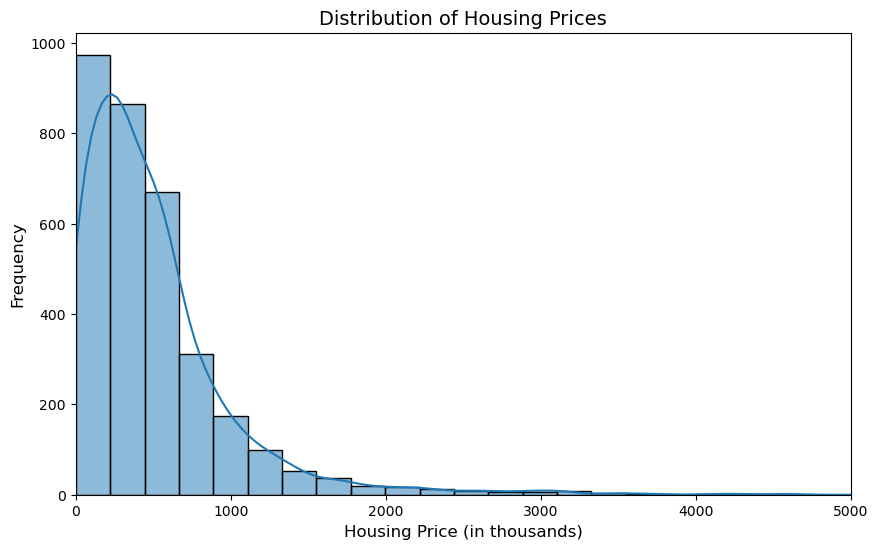

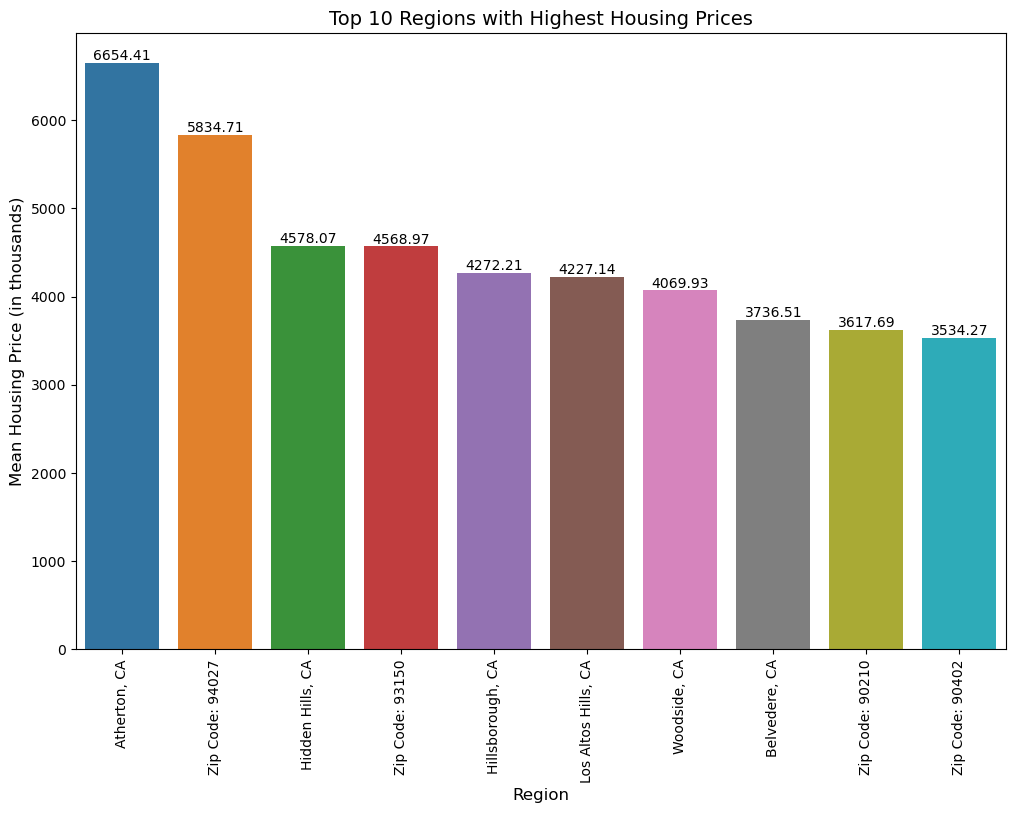

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(House_median['Mean_Price_Yearly'], kde=True, bins=30)
plt.xlabel('Housing Price (in thousands)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Housing Prices', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0, 5000)  # Adjust the x-axis limit for better readability
plt.show()

sorted_data = new_House_median.sort_values(by='Mean_Price_Yearly', ascending=False)

# Select the top 10 regions with the highest housing prices
top_regions = sorted_data['Region'].head(10)
top_prices = sorted_data['Mean_Price_Yearly'].head(10)

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=top_regions, y=top_prices)

# Add value labels to the bars
for i, v in enumerate(top_prices):
    ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Region', fontsize=12)
plt.ylabel('Mean Housing Price (in thousands)', fontsize=12)
plt.title('Top 10 Regions with Highest Housing Prices', fontsize=14)

plt.show()

I wanted to include this visualization just to better grasp the data and see where a large majority of data points will be located in, in our case the majority is at or below $300,000.  

Further, I graphed the 10 highest housing prices also out of curiosity and further data insight to see just how much our data can vary.  In this case we see that Atherton is by far the highest, being well over $6,600,000.  

## Data Splitting and Scaling

The purpose of splitting the data into training and testing sets is to evaluate the performance of the model on unseen data.  We are also conducting feature scaling to ensure that the features are on a similar scale, hopefully to ensure better performance.

For splitting data, we went forward with using the common 80/20 split.  

In [35]:
# Split data
X = new_House_median[price_columns]
y = new_House_median['Mean_Price_Yearly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Before we train our model, I wanted to look into the best performing alpha level through regularization hyperparameter tuning.  The best performer here will then be used in our training data.     


In [8]:
# Train model with regularization and hyperparameter tuning
alphas = [0.01, 0.1, 1.0, 10.0]
best_alpha = None
best_score = -np.inf
for alpha in alphas:
    model = Ridge(alpha=alpha)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train)

Ridge(alpha=10.0)

The evaluation metrics (mean squared error, mean absolute error, and R-squared) provide an insight into the model's predictive accuracy and the quality of the predictions on the unseen test data.

In [9]:
# Evaluate model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 0.03443377577919562
Mean Absolute Error: 0.07223821380913234
R-squared: 0.9999998933054143


With our metrics returned, we can gain insight on initial performance.  A low Mean Squared Error(MSE) like in our case can suggest our model is making acurate predictions with small errors on average.  Similarly, a relatively low Mean Absolute Error(MAE) indicates the model is, on average, making close to actual housing price predictions in the test set.  Finally, an R-squared value very close to 1 suggests that the model is highly effective at predicting housing prices based on the features in the dataset.

The three of these all point to our model likely being a decent and reliable tool for forecasting housing prices in the real world.  However, we do have a serious risk of overfitting especially with our R-squared being close to 1.  The value of 1 could mean that the model isn't discovering underlying trends or relationships, but instead just filling in with the noise.  

In [38]:
# Cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores.mean())

Cross-validated MSE: 0.19719294880011579


With a Cross-validated MSE of 0.1972, it furthers our risk of overfitting.  The higher cross-validated MSE value suggests that the model may not be generalizing as well as the test set performance suggests. The discrepancy between the test set MSE and the cross-validated MSE points to the possibility of overfitting, where the model has fit the training data too closely and is not performing as well on new data.

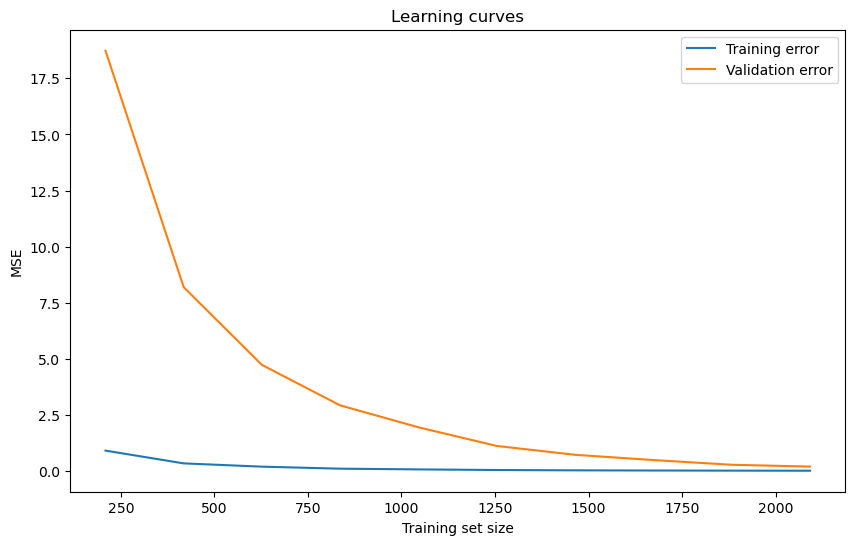

In [39]:
# Learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    model, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, validation_scores_mean, label='Validation error')
plt.title('Learning curves')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.legend()
plt.show()

Once again, the learning curves shown above also point to the possibility of overfitting.  The model is able to fit the training data quite well, seen with the decreasing training error. However, the validation error decreases at a faster rate, suggesting the model may be overfitting and not generalizing as effectively to the validation data.  

In [40]:
# Save model and scaler
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

Despite the risk of overfitting, we will save our model and scaler.  Saving them allows for us to call on them later when we want to make predictions on new data - the whole reason I chose this dataset and idea.

## Data Test Preparation

We will start with separating our data with train and test data, training set being up to December 2022 and our testing set from January 2023 onwards.

In [41]:
# Split the data into training and testing periods
train_end_date = 'December 2022'
train_data = new_House_median.loc[:, :'December 2022']
test_data = new_House_median.loc[:, 'January 2023':]

# Calculate the 'Mean_Price_Yearly' column for train_data and test_data
train_data['Mean_Price_Yearly'] = train_data.iloc[:, 1:].mean(axis=1)
test_data['Mean_Price_Yearly'] = test_data.iloc[:, 1:].mean(axis=1)

We also went ahead and calculated the means as the target variable should represent the overall yearly trend.

In [42]:
# Update the price_columns to include only the columns present in train_data
price_columns_train = train_data.columns[1:-1]  # Exclude 'Region' and 'Mean_Price_Yearly'

Updating the columns ensures that after splitting the train_data and test_data, they both have the same amount of columns and column names.

Moreover, the purpose of these steps is to prepare the data for training and testing the Ridge regression model.

In [46]:
# Prepare the training data
X_train = train_data[price_columns_train]
y_train = train_data['Mean_Price_Yearly']

# Scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the model on the training data
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train)

Ridge(alpha=10.0)

This code will perform a backtest of the Ridge regression model on the test data, this will let us get a more realistic picture of the models generalization capabilities beyond the training set.

In [47]:
# Prepare the testing data
X_test = test_data.reindex(columns=price_columns_train, fill_value=0)
y_test = test_data['Mean_Price_Yearly']
X_test_scaled = scaler.transform(X_test)

# Make predictions on the testing data
y_pred = model.predict(X_test_scaled)

# Calculate the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Backtesting Results:")
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Backtesting Results:
Mean Squared Error: 945875.9479780057
Mean Absolute Error: 679.2751933604271
R-squared: -0.9524286486383078


As we have seen before, the low R-squared value of -0.95 suggests that the model is not performing well on the test data and once again, strongly indicates the risk of overfitting.  

We will carry on with this despite the overfitting as I believe seeing the impact of overfitting can serve as a learning opportunity, especially on a project where I want to gain familiarity with a new topic.   

## Initial Implementation and Results

Here, we will be able to finally test out our model and see it in action.  When this is ran, the user will be prompted to enter a city/zip code, a month and then a future year - such as San Diego, 1, 2026.  From here, the code will be ran and it will return the predicted price for said date and it will create a graph showcasing the city/zipcodes housing prices history just to see how the past holds up with the future.

Enter the city or zip code (e.g., 'San Diego, CA' or '91917'): San Diego
Enter the future month (MM): 1
Enter the future year (YYYY): 2026
Predicted housing price for San Diego in 1/2026: $612.20


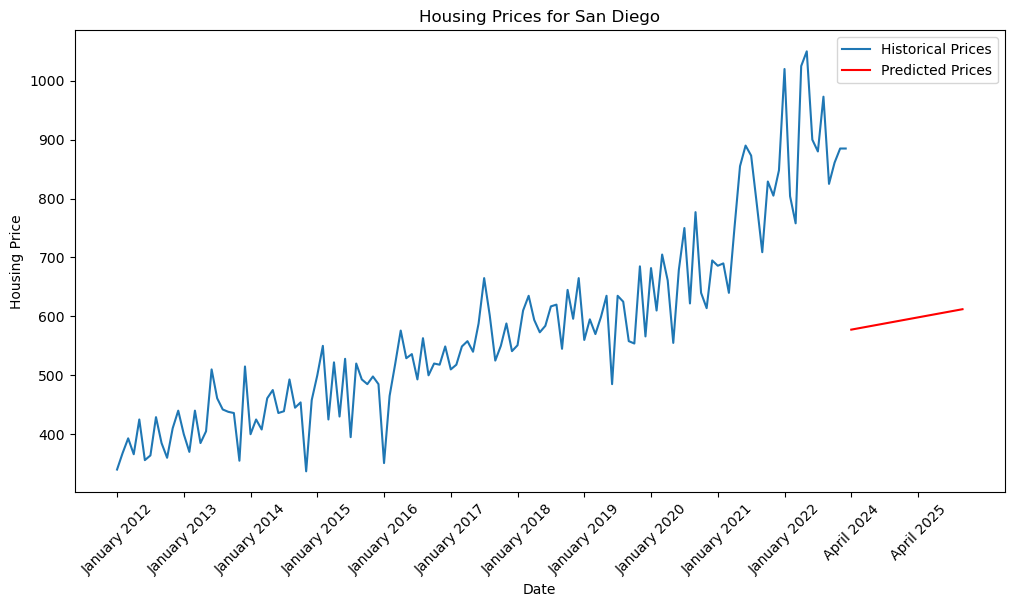

In [48]:
# User input for prediction
city_or_zip = input("Enter the city or zip code (e.g., 'San Diego, CA' or '91917'): ")
future_month = input("Enter the future month (MM): ")
future_year = input("Enter the future year (YYYY): ")

# Data preparation for prediction
region_data = new_House_median[new_House_median['Region'].str.contains(city_or_zip, case=False)]
if region_data.empty:
    print("No data found for the specified city or zip code.")
else:
    future_data = region_data[price_columns_train]
    future_data_scaled = scaler.transform(future_data)

    # Predict future price
    current_date = datetime.datetime.now()
    future_date = datetime.datetime(int(future_year), int(future_month), 1)
    months_difference = (future_date.year - current_date.year) * 12 + future_date.month - current_date.month

    # Generate dates for prediction
    prediction_dates = pd.date_range(start=current_date.strftime('%Y-%m'), end=future_date.strftime('%Y-%m'), freq='M')
    prediction_prices = [model.predict(future_data_scaled)[0] * (1 + 0.003 * ((date.year - current_date.year) * 12 + date.month - current_date.month)) for date in prediction_dates]

    print(f"Predicted housing price for {city_or_zip} in {future_month}/{future_year}: ${prediction_prices[-1]:.2f}")

    # Plot historical and predicted prices
    plt.figure(figsize=(12, 6))
    historical_data = region_data[price_columns_train]
    plt.plot(historical_data.columns, historical_data.iloc[0], label='Historical Prices')

    # Format predicted dates to match historical date format
    predicted_dates_formatted = [date.strftime('%B %Y') for date in prediction_dates]
    plt.plot(predicted_dates_formatted, prediction_prices, color='red', label='Predicted Prices')

    plt.xlabel('Date')
    plt.ylabel('Housing Price')
    plt.title(f"Housing Prices for {city_or_zip}")
    plt.legend()

    # Set the x-axis tick labels to display every 12 months (1 year) for both historical and predicted dates
    all_dates = pd.concat([pd.Series(historical_data.columns), pd.Series(predicted_dates_formatted)])
    plt.xticks(all_dates[::12], rotation=45)

    plt.show()

Our forecast showcases an interesting deviation from the uptrend we can see from historical data.  While this isn't impossible, I believe that the model struggles to accurately predict future price movement.  This struggle could be from additional underlying factors such as interest rates or politics that I failed to consider.  

## Discusion/Conclusion

Unfortunately, the overall performance of my Ridge Regression model wasn't the perfect as the results only suggested overfitting.  Several factors may contribute to this overfitting issue, such as the high complexity of the Ridge regression model.  Additionally, the time-based split between the training and testing sets may have created a mismatch, as the housing market conditions could have evolved in ways the model was unable to adapt to.  Moving forward, utilizing more rigorous cross-validation could provide a more robust estimate of the model's performance on out-of-sample data. Analyzing the relative importance of the input features could also shed light on any potential over-reliance on specific characteristics.

Despite all of this, I still learned a great deal in terms of being able to research and locate relevant data for a project.  I learned how to implement machine learning algorithms to sort of answer my own questions and interests.  I do believe that addressing the limitations, the prediction model can be enhanced to provide reliable forecasting.   

Thank you again.